#### Experiment (I). Hiearhical Counting

In [1]:
# The issue with this counting sequence is that it has batch size of 1 only 
# it's fine for now, but clearly a fourier series decomposition is more beautiful

# (I). Counting Sequence
# --------------------------------------------------------------------------------
from collections import defaultdict
import torch

# (I.1) Generate Counting Sequence
# ----------------------------------------------------
def generate_level(l: int, seq: list, t: int, L: int, K: int): 
    if l < L:
        seq[l] += str(l)
        if t % K == 0: 
            return generate_level(l+1, seq, t // K, L, K)
    return seq

def generate_count_seq(L: int, K: int, T: int): 
    seq = defaultdict(str)
    for t in range(1, T+1): 
        seq = generate_level(0, seq, t, L, K)
    return seq
# ----------------------------------------------------

# (I.2) Tokenizer (basic integer tokenizer)
# ----------------------------------------------------

class TinyTokenizer: 
    def __init__(self, vocab: dict):
        self.vocab = {str(k): v for k, v in vocab.items()}
        self.vocab_size = len(vocab)

    def __call__(self, seq: str):
        return [self.vocab[c] for c in seq]

# ----------------------------------------------------


# (I.3) Tensor idx sequence preparation 
# ----------------------------------------------------

L = 3
K = 2
T = 200

data = generate_count_seq(L, K, T)
tokenizer = TinyTokenizer({str(k): k for k in range(10)})

idx = [tokenizer(seq) for seq in data.values()]
idx += [[] for _ in range(L - len(idx))]
samples = [(idx, None)]

from model import GATConfig, GAT, HierSeq
from utils import stream_print_hseq
from torch.optim import Adam 

config = GATConfig(K=K, L=L, n_embd=128, n_head=4, device="cpu", _compile=False)
gat = GAT(config)

# .from_hiearchical_data has error: prepared token is NOT interleaved with correct causal ordering
batch_data = HierSeq.from_hierarchical_data(samples, K=gat.K, L=gat.L)
stream_print_hseq(batch_data) # sanity check

# Batched Forward Propagation
epochs = 20
# gat.train()


# Training Loop : learning just fine -- loss reduces quickly
# ----------------------------------------------------
optimizer = Adam(gat.parameters(), lr=1e-3)

for epoch in range(epochs):
    loss = gat(batch_data)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")
    # break
# ----------------------------------------------------


Hierarchical Sequence K=2 L=3 (aligned by timestamp):
-------------------------------------------------------
Level 2:                 [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2]             [2] 
Level 1:         [1]     [1]     [1]     [1]     [1]     [1]     [1]     [1

In [2]:
from utils import * 


test_data = generate_count_seq(L, K, 1)
idx = [tokenizer(seq) for seq in test_data.values()]
idx += [[] for _ in range(L - len(idx))]
test_samples = [(idx, None)]
test_batch_data = HierSeq.from_hierarchical_data(test_samples, K=gat.K, L=gat.L)


for _ in range(25): 
    gat.generate(test_batch_data)
    stream_print_hseq(test_batch_data)
    time.sleep(0.5)


Hierarchical Sequence K=2 L=3 (aligned by timestamp):
-------------------------------------------------------
Level 2:                 [2]             [2]             [2]                 
Level 1:         [1]     [1]     [1]     [1]     [1]     [1]     [1]         
Level 0:     [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] [0] 
Total tokens: 26, Max timestamp: 16



#### Self-Organizing Reinforcement Learning
1. A more exciting question is how can I build a GAT module for a Snake game? It'll be the natural test-bed for SoRL -- a snake with inner-monologue. 
2. Decision Abstractive Transformer (DAT).


In [ ]:
from snake import SnakeGameEngine, collect_trajectories, RandomAgent
from utils import HierTraj, data_sanity_check
from constant import PLACE_HOLDER_STATE_TOK, PLACE_HOLDER_ACTION_TOK

env = SnakeGameEngine(width=10, height=10)

# This is a make-shift data collection pipeline, the abstract tokens are complete false. 
# The proper way to collect data, per SoRL, is to 'simulate' multiple actions on the environment and store the HierTraj state directly
# in that sense, the code snippet in the middle is not useful...

# A way to use 'expert trajectory' is to take in the 'trajectories', and have the agent 'learn / explore' on what abstract tokens can be 
# used to explain the trajectory. This is very similar to the 'intuitive-physics' based 'learning by surprise' or 'active learning from obs' 
# idea. 

# For what is worth, the mid-snippet is useless (besides serving as a toy-case on which we test on SSL training of GAT)

# Collect trajectories
trajectories = collect_trajectories(env, RandomAgent(env), num_episodes=5, device="cpu")

samples = []
for trajectory in trajectories: 

    n_state = trajectory[0].size(0)
    placeholder_tokens = [PLACE_HOLDER_STATE_TOK if i % 2 == 0 else PLACE_HOLDER_ACTION_TOK for i in range(2*n_state-1)]
    sample = ([placeholder_tokens, [3, 9, 4, 2], [19, 14]], None)
    samples.append(sample)

batch_data = HierTraj.from_hierarchical_data(samples, K=3, L=3)
data_sanity_check(batch_data, trajectories)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
Episode 0: Score=0, Reward=-11.6
Episode 1: Score=0, Reward=-10.6
Episode 2: Score=0, Reward=-10.6
Episode 3: Score=0, Reward=-10.9
Episode 4: Score=0, Reward=-11.3
Sanity check passed: total 115 0-th level tokens (state & action)
Sanity check passed: 60 state tokens in data, 60 state tokens in trajectories
Sanity check passed: 55 action tokens in data, 55 action tokens in trajectories
Sanity check passed: 145 (action/state/abstract) tokens in data


In [1]:
from model import DAT, DATConfig

# DAT model 

config = DATConfig(
    n_layer=4,
    n_head=2,
    n_embd=32,
    K=2,
    L=3,
    vocab_size_list=[64, 32],
    device="cpu",
    _compile=True,
)

# Snake specific encoder & decoder for state & action
from snake import StateEncoder, StateDecoder, ActionEncoder, ActionDecoder

state_encoder = StateEncoder(height=10, width=10, feature_dim=config.n_embd)
state_decoder = StateDecoder(height=10, width=10, feature_dim=config.n_embd)
action_encoder = ActionEncoder(action_size=4, feature_dim=config.n_embd)
action_decoder = ActionDecoder(action_size=4, feature_dim=config.n_embd)

dat = DAT(config, state_encoder, state_decoder, action_encoder, action_decoder)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# compute loss
loss = dat(batch_data, trajectories)

# generate & update 
new_batch_data, new_trajectories = dat.generate(batch_data, trajectories)

# act: produce action tokens (if there already exists action-tokens un-grounded with reward, skip it)
pairs = dat.act(batch_data, trajectories) # list of (sample_idx, action_idx)


In [4]:
# Validate on 'order of generation'
from utils import test_dat_gen_order

# Sanity check-up function (order of generation)
test_dat_gen_order(dat, env, L=3, K=2, n_gen=10)


Hierarchical Trajectory K=2 L=3 (aligned by timestamp):
-------------------------------------------------------
Level 2:              [0]     
Level 1:      [0]     [0]     
L0-State: [s] [s] [s] [s]     
L0-Action:    [a] [a] [a] [a] 
Total tokens: 11, Max timestamp: 4



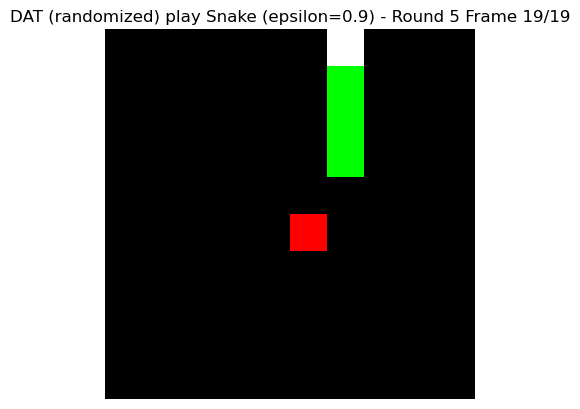

: 

In [ ]:
# Does DAT dream of playing snake game?

# from agent import HiearchicalAgent
from snake import SnakeGameEngine
from utils import draw_gif
from agent import collect_dat_game_play_frames
from agent import HiearchicalAgent

# Environment
env = SnakeGameEngine(width=10, height=10)

# DAT Agent (Snake specific agent)
# agent = HiearchicalAgent(dat, env.reset(), "cpu")

# DAT plays the snake game
# --------------------------------------------------------------------------------------------------------------------------
epsilon = 0.9
frames = collect_dat_game_play_frames(dat, env, epsilon=epsilon)
draw_gif(frames, txt=f"DAT (randomized) play Snake (epsilon={epsilon})", path="./visual/dat_snake.gif")

$\textbf{Concern 1.}$ Random action selection is implemented outside DAT, this implies (potentially) skipping of abstract tokens -- is it valid? 
- I think it's probably better to modify the 'update' method in agent class to always 'replace' action (instead of assuming it's updated already). 
- We should always call the 'dat.act' function, so that it'd generate all necessary abstract tokens upto the next action token (with correctly updated 
  state but wrongly updated trajectory), and we'd replace the selected action with a random selected one with probability epsilon and then replace the 
  action tensor in the trajectory. 

(TBD)
- (Done) Random action selection perturbation 
- DRA algorithm

In [ ]:
# DRA, Hyperball trick, SoRL

def discovery_refinement_advantage()


In [4]:
# Comparative studies required between GAT and other hiearchical models, such as 'adaptive-chunk', 'byte-latent', 'hiearchical-reasoning', 'JEPA' to name a few. 